<a href="https://colab.research.google.com/github/DevSingh28/Birds_classification/blob/main/Bird_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This step is to download the dataset from kaggle directly into colab (Search on yt for download solution or conatct me)
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download gpiosenka/100-bird-species

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/100-bird-species
License(s): CC0-1.0
100% 1.95G/1.96G [00:13<00:00, 188MB/s]
100% 1.96G/1.96G [00:13<00:00, 154MB/s]


In [ ]:
# Unzip the downloaded file
import zipfile
re = zipfile.ZipFile('100-bird-species.zip')
re.extractall()
re.close()

In [ ]:
# Create path to different directories
train_dir = '/content/train'
test_dir = '/content/test'
valid_dir = '/content/valid'

In [ ]:
# Necessary imports
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# Create batch size and format the test, train and valid data
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 batch_size=32,
                                                                 image_size=(224, 224))
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 batch_size=32,
                                                                 image_size=(224, 224))
valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                 batch_size=32,
                                                                 image_size=(224, 224))

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [ ]:
# create class name (There are many more methods to create class_name basically not create to fetch class names)
import numpy as np
class_names = train_data.class_names
np.shape(class_names)

(525,)

In [ ]:
class_names[:10]

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS']

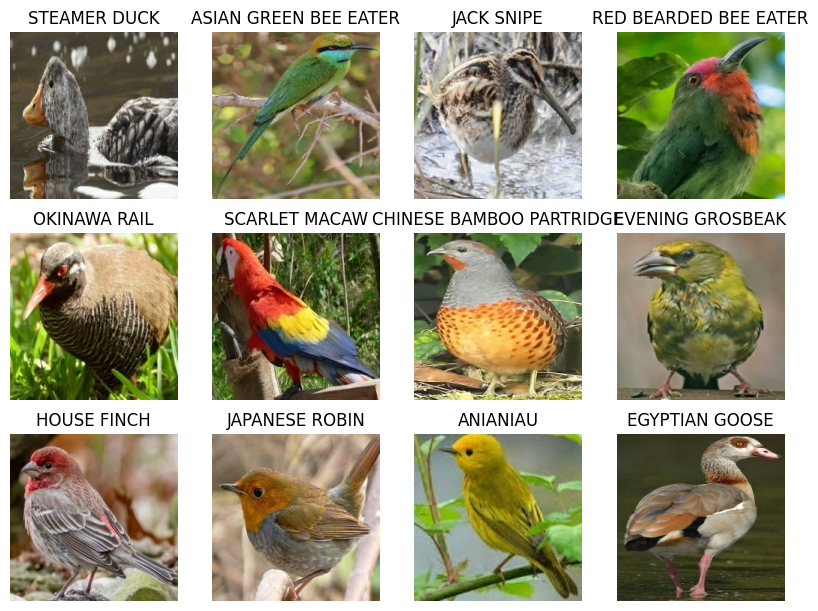

In [ ]:
# Visualise some data
plt.figure(figsize=(10, 10))
for images,labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Create data augmentation layer
data_aug_layer = keras.Sequential([
    preprocessing.RandomFlip('horizontal_and_vertical'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
])

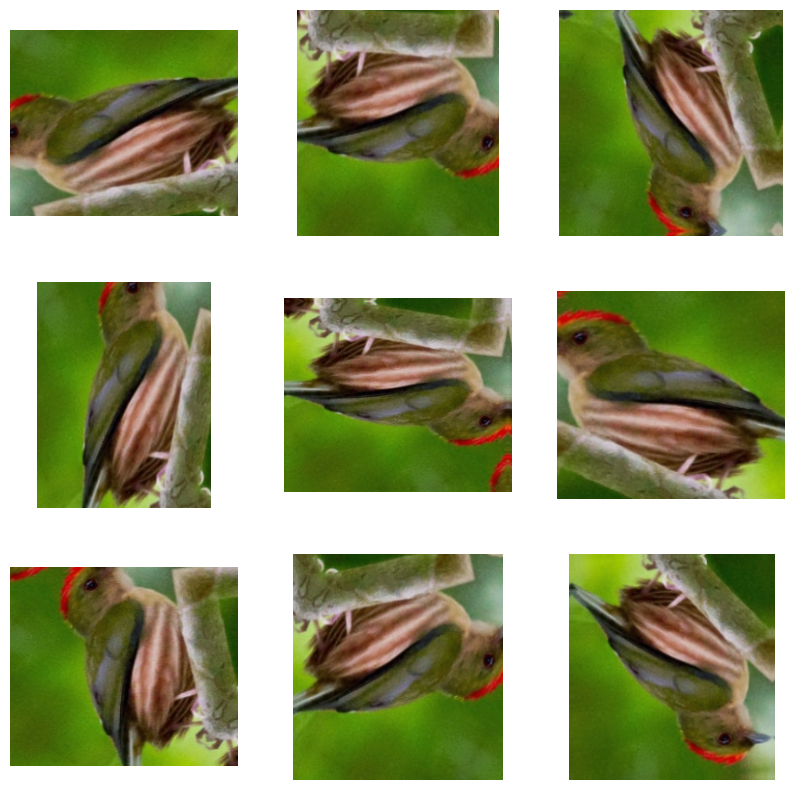

In [ ]:
# Visualise data after applying aug layer
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_aug_layer(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Creating Model (Add or remove layer according to yourself)

inputs = keras.Input(shape=(224, 224, 3))
x = data_aug_layer(inputs)
x = layers.Rescaling(1./255)(inputs)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 111, 111, 32)      128   

In [ ]:
# Creating ModelCheckpoint callback

path = '/content/model_saver/checkpoints.ckpt'
check_point_caller = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                        save_weights_only = True,
                                                        save_best_only=True)

In [ ]:
# Compile model (Use sparse_categorical_crossentropy if label_mode=int and use categorical_crossentropy if label_mode=categorical)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Fit the model use gpu for fast process and you can also use Earlystopping

history = model.fit(
    train_data,
    epochs=20,
    validation_data=valid_data,
    callbacks=[check_point_caller])

Epoch 1/20
2645/2645 [==============================] - 199s 71ms/step - loss: 5.0687 - accuracy: 0.0738 - val_loss: 3.1712 - val_accuracy: 0.3196
Epoch 2/20
2645/2645 [==============================] - 185s 70ms/step - loss: 3.1696 - accuracy: 0.3172 - val_loss: 1.8309 - val_accuracy: 0.6008
Epoch 3/20
2645/2645 [==============================] - 184s 69ms/step - loss: 2.2921 - accuracy: 0.4820 - val_loss: 1.2888 - val_accuracy: 0.7036
Epoch 4/20
2645/2645 [==============================] - 186s 70ms/step - loss: 1.8589 - accuracy: 0.5710 - val_loss: 0.9927 - val_accuracy: 0.7627
Epoch 5/20
2645/2645 [==============================] - 184s 70ms/step - loss: 1.5803 - accuracy: 0.6258 - val_loss: 0.9113 - val_accuracy: 0.7928
Epoch 6/20
2645/2645 [==============================] - 185s 70ms/step - loss: 1.3891 - accuracy: 0.6683 - val_loss: 0.7490 - val_accuracy: 0.8179
Epoch 7/20
2645/2645 [==============================] - 185s 70ms/step - loss: 1.2408 - accuracy: 0.6975 - val_loss: 0

In [ ]:
model.evaluate(test_data)

83/83 [==============================] - 2s 24ms/step - loss: 0.2877 - accuracy: 0.9257


[0.28770551085472107, 0.9257143139839172]

Text(0.5, 1.0, 'Training and Validation Loss')

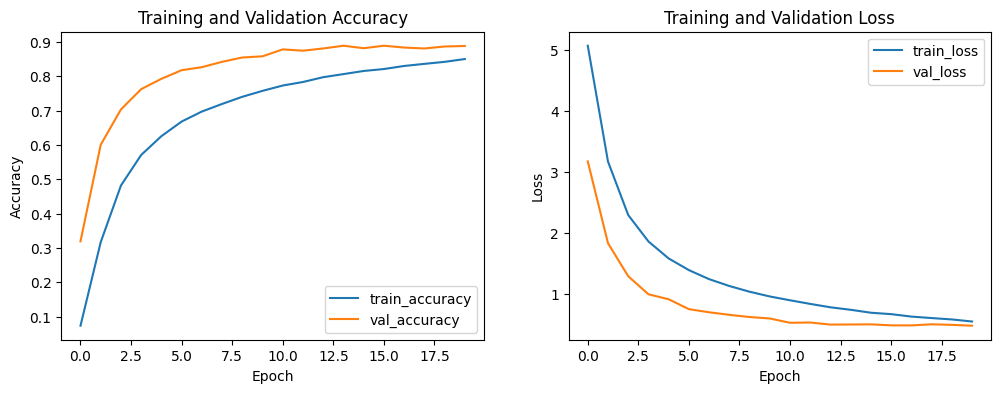

In [ ]:
# Let's create plot and check accuracy and loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

In [ ]:
pred = model.predict(test_data)

83/83 [==============================] - 3s 27ms/step


In [ ]:
np.argmax(pred[0])

524

In [ ]:
# Function to predict on images
from tensorflow.keras.utils import load_img, img_to_array
def predictor(filename, class_names):
    img = load_img(filename,target_size=(224,224))
    imgconv = img_to_array(img)
    img_array = np.expand_dims(imgconv,axis=0)
    pred = np.argmax(model.predict(img_array))
    predimg = class_names[pred]
    predver = np.max(model.predict(img_array))
    pred
    plt.imshow(img)
    plt.axis(False)
    plt.title("Prediction: {}, Confidence: {}".format (predimg, predver))

1/1 [==============================] - 0s 19ms/step


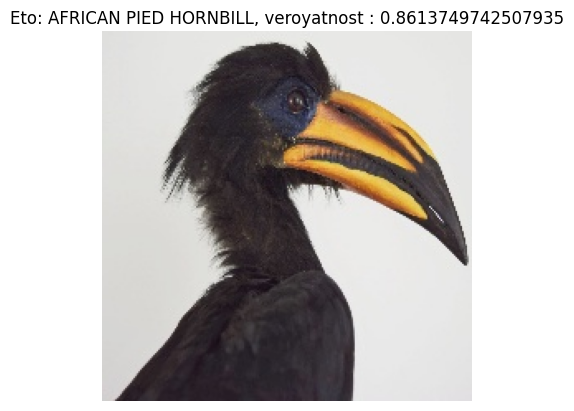

In [ ]:
predictor('/content/test/AFRICAN PIED HORNBILL/1.jpg', class_names)

1/1 [==============================] - 0s 18ms/step


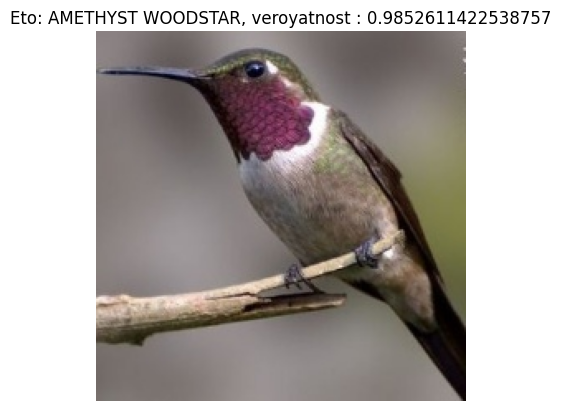

In [ ]:
predictor('/content/test/AMETHYST WOODSTAR/1.jpg', class_names)

In [ ]:
model.save('my_model')

In [ ]:
model.save(filepath='/content/drive/MyDrive')